In [1]:
%load_ext autoreload
%autoreload 2

In [2]:
from fl_g13.config import RAW_DATA_DIR, PROJ_ROOT
from torchvision import datasets, transforms

from fl_g13.modeling import train
import torch
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

2025-04-22 17:29:38.930 | INFO     | fl_g13.config:<module>:11 - PROJ_ROOT path is: C:\Users\taran\Desktop\coding\polito\mldl\FedLearn Exam Project\fl-g13


# Test NN

In [3]:
transform = transforms.Compose([
    transforms.ToTensor()
])
cifar100_train = datasets.CIFAR100(root=RAW_DATA_DIR, train=True, download=True, transform=transform)
cifar100_test = datasets.CIFAR100(root=RAW_DATA_DIR, train=False, download=True, transform=transform)

In [4]:
class TinyCNN(nn.Module):
    def __init__(self, num_classes=100):
        super(TinyCNN, self).__init__()
        self.conv1 = nn.Conv2d(3, 16, 3, padding=1)
        self.conv2 = nn.Conv2d(16, 32, 3, padding=1)
        self.fc1 = nn.Linear(32 * 8 * 8, num_classes)

        # Store configuration for later loading
        # This is a bit of a hack, but we need to store the number of classes
        self._config = {
            "num_classes": num_classes,
            # In fact, the followings could be avoided as from_config loads only the num_classes
            "conv1_out_channels": 16,
            "conv2_out_channels": 32,
            "fc1_in_features": 32 * 8 * 8,
        }

    def forward(self, x):
        x = F.relu(self.conv1(x))     # -> [B, 16, 32, 32]
        x = F.max_pool2d(x, 2)        # -> [B, 16, 16, 16]
        x = F.relu(self.conv2(x))     # -> [B, 32, 16, 16]
        x = F.max_pool2d(x, 2)        # -> [B, 32, 8, 8]
        x = x.view(x.size(0), -1)     # -> [B, 32*8*8]
        x = self.fc1(x)               # -> [B, 100]
        return x

    # Now we need to be careful to define how to load from config
    @classmethod
    def from_config(cls, config):
        return cls(num_classes=config["num_classes"])

In [5]:
CHECKPOINT_DIR = str(PROJ_ROOT / "checkpoints")

# Parameters
batch_size  = 32
start_epoch = 1
num_epochs  = 6
save_every  = 2

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

train_dataloader = torch.utils.data.DataLoader(cifar100_train, batch_size=batch_size, shuffle=True)
test_dataloader = torch.utils.data.DataLoader(cifar100_test, batch_size=batch_size, shuffle=True)

model = TinyCNN(100)
model.to(device)
optimizer = optim.AdamW(model.parameters(), lr=1e-4, weight_decay=0.04)
criterion = torch.nn.CrossEntropyLoss()

In [ ]:
_, _, _, _ = train(
    checkpoint_dir = CHECKPOINT_DIR,
    name = "first_train",
    train_dataloader = train_dataloader,
    val_dataloader = test_dataloader,
    criterion = criterion,
    start_epoch = start_epoch,
    num_epochs = num_epochs,
    save_every = save_every,
    backup_every = None,
    model = model,
    optimizer = optimizer,
    scheduler = None,
    verbose = False,
)

No prefix/name for the model was provided, choosen prefix/name: fluffy_charizard_63

🚀 Epoch 1/6 (16.67%) Completed
	📊 Training Loss: 4.0813
	✅ Training Accuracy: 9.28%
	⏳ Elapsed Time: 19.97s | ETA: 99.85s
	🕒 Completed At: 17:30
🔍 Validation Results:
	📉 Validation Loss: 3.8017
	🎯 Validation Accuracy: 14.00%

🚀 Epoch 2/6 (33.33%) Completed
	📊 Training Loss: 3.6541
	✅ Training Accuracy: 16.58%
	⏳ Elapsed Time: 20.34s | ETA: 81.36s
	🕒 Completed At: 17:30
🔍 Validation Results:
	📉 Validation Loss: 3.5937
	🎯 Validation Accuracy: 18.23%

💾 Saved checkpoint at: C:\Users\taran\Desktop\coding\polito\mldl\FedLearn Exam Project\fl-g13\checkpoints\TinyCNN\fluffy_charizard_63_TinyCNN_epoch_2.pth
💾 Saved losses and accuracies (training and validation) at: C:\Users\taran\Desktop\coding\polito\mldl\FedLearn Exam Project\fl-g13\checkpoints\TinyCNN\fluffy_charizard_63_TinyCNN_epoch_2.loss_acc.json

🚀 Epoch 3/6 (50.00%) Completed
	📊 Training Loss: 3.4810
	✅ Training Accuracy: 19.69%
	⏳ Elapsed Time: 20.6

📈 Loss and Accuracy data correctly loaded


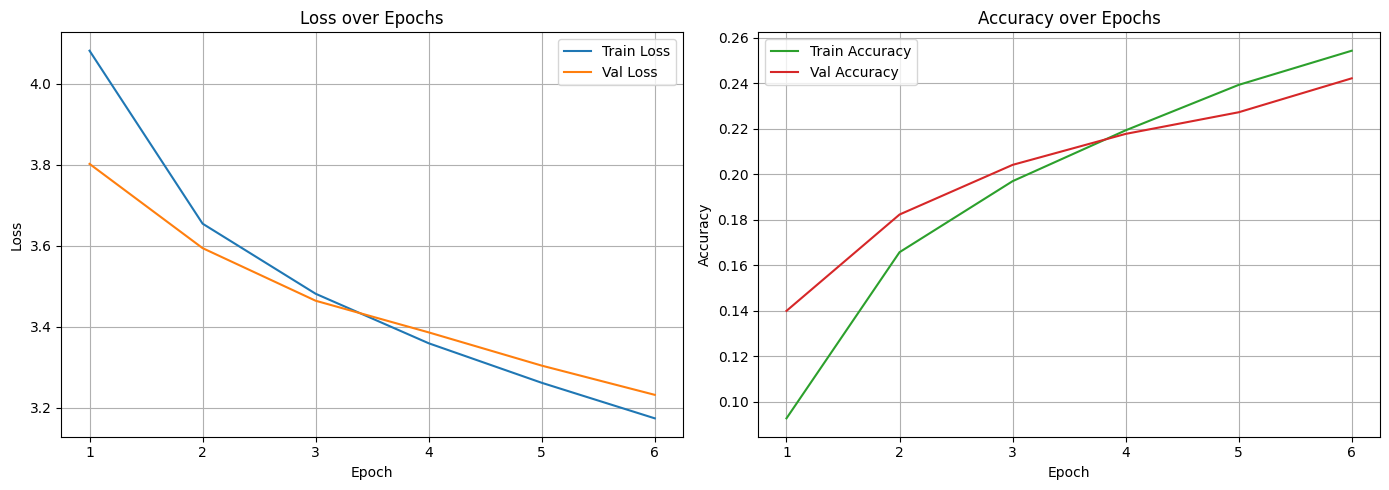

In [ ]:
from fl_g13.modeling.load import load_loss_and_accuracies, plot_metrics

plot_metrics(path = CHECKPOINT_DIR + '\\first_train_TinyCNN_epoch_6.loss_acc.json')

In [ ]:
metrics = load_loss_and_accuracies(path = CHECKPOINT_DIR + '\\first_train_TinyCNN_epoch_6.loss_acc.json', verbose=True)


📈 Loss and Accuracy data correctly loaded
	Keys found: ['train_loss', 'val_loss', 'train_acc', 'val_acc', 'train_epochs', 'val_epochs']


In [ ]:
from fl_g13.modeling.load import load

loaded_model, resume_epoch = load(
    path = CHECKPOINT_DIR + '\\first_train_TinyCNN_epoch_6.json',
    model_class = TinyCNN,
    device=device,
    optimizer=optimizer,
    verbose=True
)

🔍 Loading checkpoint from C:\Users\taran\Desktop\coding\polito\mldl\FedLearn Exam Project\fl-g13\checkpoints\TinyCNN\fluffy_charizard_63_TinyCNN_epoch_6.pth
📦 Model class in checkpoint: TinyCNN
⚙️ Optimizer class in checkpoint: AdamW
🔧 Model configuration: {'num_classes': 100, 'conv1_out_channels': 16, 'conv2_out_channels': 32, 'fc1_in_features': 2048}
✅ Loaded checkpoint from C:\Users\taran\Desktop\coding\polito\mldl\FedLearn Exam Project\fl-g13\checkpoints\TinyCNN\fluffy_charizard_63_TinyCNN_epoch_6.pth, resuming at epoch 7


In [ ]:
# Resume training

_, _, _, _ = train(
    checkpoint_dir = CHECKPOINT_DIR,
    name = "second_train",
    train_dataloader = train_dataloader,
    val_dataloader = test_dataloader,
    criterion = criterion,
    start_epoch = resume_epoch,
    num_epochs = 6,
    save_every = 2,
    backup_every = None,
    model = loaded_model,
    optimizer = optimizer,
    scheduler = None,
    verbose = False,
)

No prefix/name for the model was provided, choosen prefix/name: spooky_ekans_38

🚀 Epoch 7/12 (58.33%) Completed
	📊 Training Loss: 3.1019
	✅ Training Accuracy: 26.84%
	⏳ Elapsed Time: 19.66s | ETA: 98.32s
	🕒 Completed At: 17:42
🔍 Validation Results:
	📉 Validation Loss: 3.2314
	🎯 Validation Accuracy: 24.21%

🚀 Epoch 8/12 (66.67%) Completed
	📊 Training Loss: 3.1020
	✅ Training Accuracy: 26.84%
	⏳ Elapsed Time: 24.77s | ETA: 99.07s
	🕒 Completed At: 17:42
🔍 Validation Results:
	📉 Validation Loss: 3.2305
	🎯 Validation Accuracy: 24.21%

💾 Saved checkpoint at: C:\Users\taran\Desktop\coding\polito\mldl\FedLearn Exam Project\fl-g13\checkpoints\TinyCNN\spooky_ekans_38_TinyCNN_epoch_8.pth
💾 Saved losses and accuracies (training and validation) at: C:\Users\taran\Desktop\coding\polito\mldl\FedLearn Exam Project\fl-g13\checkpoints\TinyCNN\spooky_ekans_38_TinyCNN_epoch_8.loss_acc.json

🚀 Epoch 9/12 (75.00%) Completed
	📊 Training Loss: 3.1020
	✅ Training Accuracy: 26.84%
	⏳ Elapsed Time: 25.83s | ETA

📈 Loss and Accuracy data correctly loaded


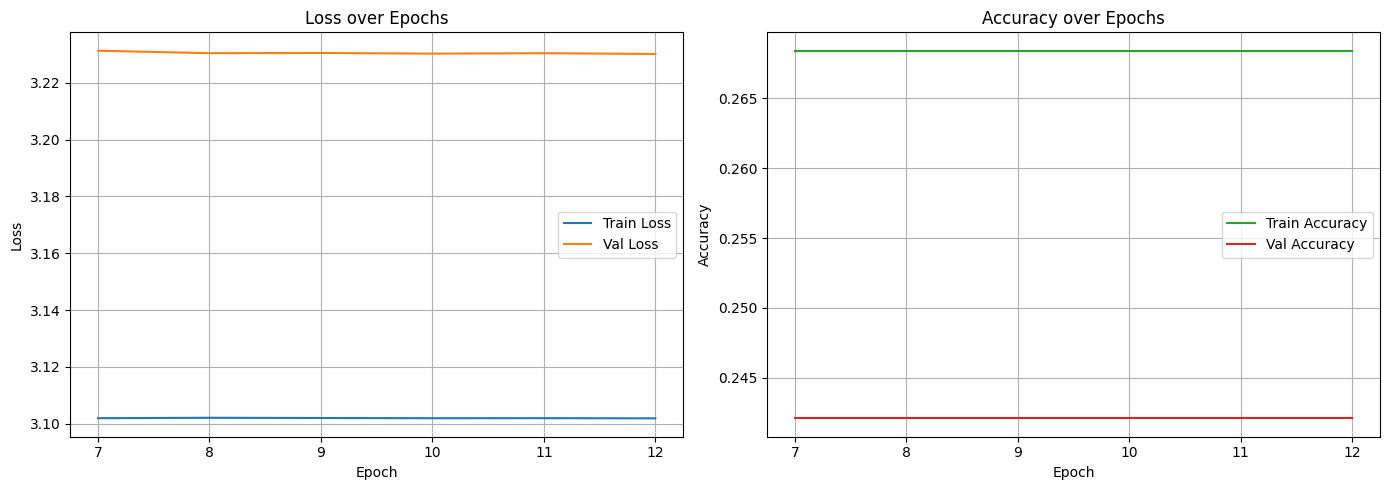

In [ ]:
plot_metrics(path = CHECKPOINT_DIR + '\\second_train_TinyCNN_epoch_12.loss_acc.json')

In [ ]:
new_metrics = load_loss_and_accuracies(path = CHECKPOINT_DIR + '\\second_train_TinyCNN_epoch_12.loss_acc.json')

📈 Loss and Accuracy data correctly loaded


In [ ]:
full_metric = dict()

for k in metrics.keys():
    full_metric[k] = metrics[k] + new_metrics[k]

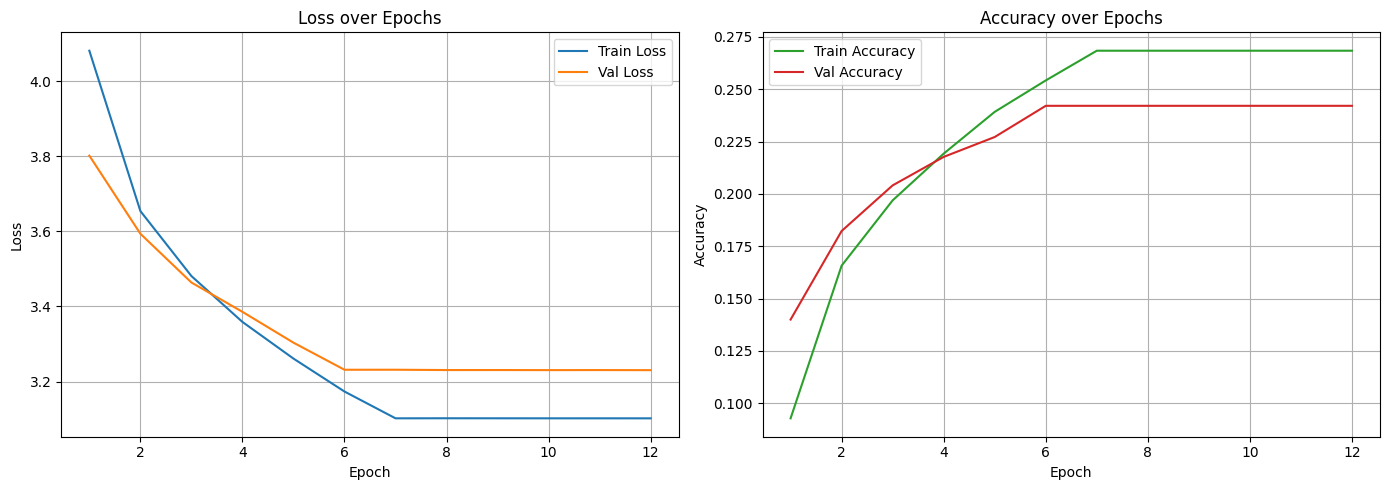

In [17]:
import matplotlib.pyplot as plt

train_epochs = full_metric['train_epochs']
val_epochs = full_metric.get('val_epochs', [])

# Crea i subplot affiancati
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(14, 5))

# --- Plot Loss ---
ax1.plot(train_epochs, full_metric['train_loss'], label='Train Loss', color='tab:blue')
if full_metric['val_loss']:
    ax1.plot(val_epochs, full_metric['val_loss'], label='Val Loss', color='tab:orange')
ax1.set_title('Loss over Epochs')
ax1.set_xlabel('Epoch')
ax1.set_ylabel('Loss')
ax1.legend()
ax1.grid(True)

# --- Plot Accuracy ---
ax2.plot(train_epochs, full_metric['train_acc'], label='Train Accuracy', color='tab:green')
if full_metric['val_acc']:
    ax2.plot(val_epochs, full_metric['val_acc'], label='Val Accuracy', color='tab:red')
ax2.set_title('Accuracy over Epochs')
ax2.set_xlabel('Epoch')
ax2.set_ylabel('Accuracy')
ax2.legend()
ax2.grid(True)

plt.tight_layout()
plt.show()